# Sampling of multivariate random variables

In [170]:
import networkx as nx

import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import least_squares
import seaborn as sns
import scipy

from pgmpy.estimators import HillClimbSearch, K2Score, BicScore, BDeuScore, BDsScore, TreeSearch
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split

import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [172]:
df = pd.read_csv('games.csv')

In [173]:
df.columns = df.columns.str.lower()

In [174]:
# Удаляем отсутствующие значения столбца year_of_release. Восстанавлявать столь малый процент (1.61) не имеет смысла.
df = df.dropna(subset=['year_of_release'])
df['year_of_release'] = df['year_of_release'].astype(np.int64)

# По тем же причинам удаляем строки с отсутвием названия игры
df = df.dropna(subset=['name'])

In [175]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = 'unknown'
df = df.fillna('unknown')

In [176]:
# df['world_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

## **Step 1**. Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 – target variables, the rest - predictors).

In [177]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,unknown,unknown,unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,unknown,unknown,unknown
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,unknown,unknown,unknown
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,unknown,unknown,unknown
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,unknown,unknown,unknown


In [178]:
df = df.query('user_score != "unknown" & rating == ["E", "T", "M"] & critic_score != "unknown"')
df['user_score'] = df['user_score'].map(float) # astype(float)
df['critic_score'] = df['critic_score'].map(float) # astype(float)
# df = pd.get_dummies(df, columns=['genre', 'rating'])
# labelencoder = LabelEncoder()
# df['platform'] = labelencoder.fit_transform(df['platform'])

In [179]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [180]:
target = df[['user_score', 'na_sales', 'other_sales']]

In [181]:
predictor = df[[
    'name', 'platform', 'year_of_release', 'eu_sales',
    'jp_sales', 'critic_score','genre', 'rating'
    ]]

In [182]:
np.isinf(target).values.sum()

0

## **Step 2.** Using univariate parametric distributions that were fitted in Lab#2 make sampling of chosen target variables. Use for this 2 different sampling methods.

In [183]:
# Random sampling
r_sampled = df.sample(frac=0.5)

In [184]:
# Inverse Transform Sampling
def inverse_ts(array, dist):
    args = dist.fit(array)
    data = np.random.uniform(size=len(array))
    its = dist(*args)
    its = its.ppf(data)
    return its

In [185]:
its_score = inverse_ts(df['user_score'], dist=stats.gamma)
its_na = inverse_ts(df['na_sales'], dist=stats.gamma)
its_oth = inverse_ts(df['other_sales'], dist=stats.gamma)

In [186]:
its_sampled = pd.DataFrame({'user_score': its_score, 'na_sales': its_na, 'other_sales': its_oth}, columns = ['user_score', 'na_sales', 'other_sales'])

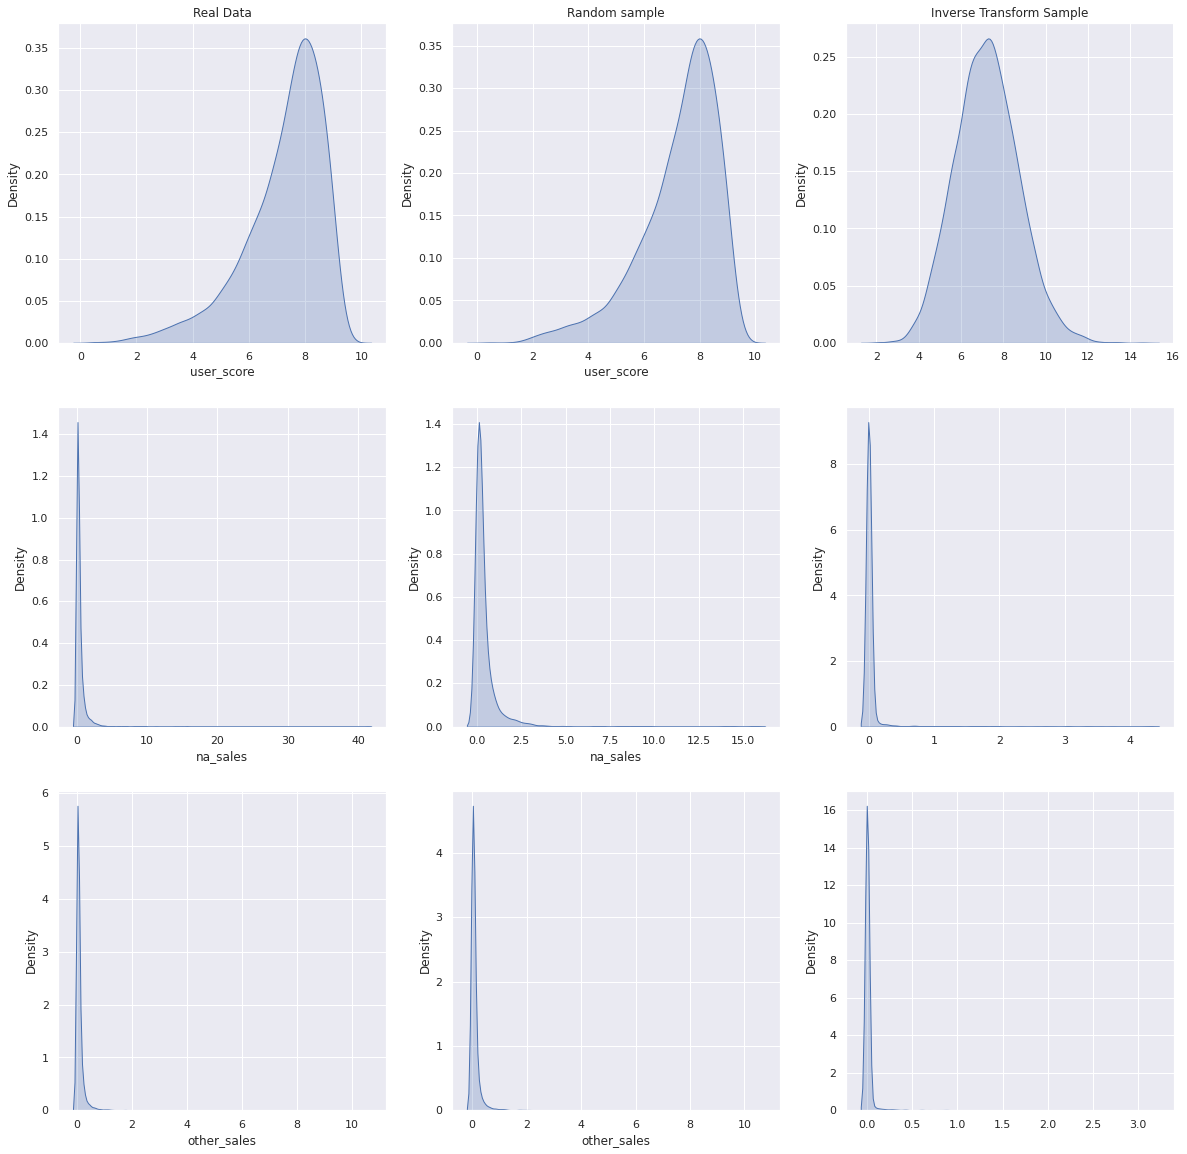

In [187]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
sns.set_theme()

ax[0, 0].set_title('Real Data')
ax[0, 1].set_title('Random sample')
ax[0, 2].set_title('Inverse Transform Sample')

sns.kdeplot(df['user_score'], ax=ax[0, 0], x='user_score', shade=True)
sns.kdeplot(r_sampled['user_score'], ax=ax[0, 1], x='user_score', shade=True)
sns.kdeplot(its_score, ax=ax[0, 2], x='user_score', shade=True)

sns.kdeplot(df['na_sales'], ax=ax[1, 0], x='na_sales', shade=True)
sns.kdeplot(r_sampled['na_sales'], ax=ax[1, 1], x='na_sales', shade=True)
sns.kdeplot(its_na, ax=ax[1, 2], x='na_sales', shade=True)

sns.kdeplot(df['other_sales'], ax=ax[2, 0], x='other_sales', shade=True)
sns.kdeplot(r_sampled['other_sales'], ax=ax[2, 1], x='other_sales', shade=True)
sns.kdeplot(its_oth, ax=ax[2, 2], x='other_sales', shade=True)

plt.show()

In [188]:
# fig, ax = plt.subplots(3, 3, figsize=(20, 20))
# sns.set_theme()

# ax[0, 0].set_title('Real Data')
# ax[0, 1].set_title('Random sample')
# ax[0, 2].set_title('Inverse Transform Sample')

# sns.histplot(df['user_score'], ax=ax[0, 0], kde=True)
# sns.histplot(r_sampled['user_score'], ax=ax[0, 1], kde=True)
# sns.histplot(its_score, ax=ax[0, 2], kde=True)

# sns.histplot(df['na_sales'], ax=ax[1, 0], kde=True)
# sns.histplot(r_sampled['na_sales'], ax=ax[1, 1], kde=True)
# sns.histplot(its_na, ax=ax[1, 2],  kde=True)

# sns.histplot(df['other_sales'], ax=ax[2, 0], kde=True)
# sns.histplot(r_sampled['other_sales'], ax=ax[2, 1], kde=True)
# sns.histplot(its_oth, ax=ax[2, 2], kde=True)

In [189]:
df[['user_score', 'na_sales', 'other_sales']].mean()

user_score 7.229289
na_sales 0.408088
other_sales 0.085617
dtype: float64

In [190]:
df[['user_score', 'na_sales', 'other_sales']].var()

user_score 2.057974
na_sales 1.041818
other_sales 0.081991
dtype: float64

Estimation of multivariate mathematical expectation and variance for inverse transform sample

In [191]:
r_sampled[['user_score', 'na_sales', 'other_sales']].mean()

user_score 7.238459
na_sales 0.418299
other_sales 0.092376
dtype: float64

In [192]:
r_sampled[['user_score', 'na_sales', 'other_sales']].var()

user_score 2.008018
na_sales 0.849187
other_sales 0.104644
dtype: float64

Estimation of multivariate mathematical expectation and variance for random sample.

In [193]:
its_sampled.mean()

user_score 7.203717
na_sales 0.033308
other_sales 0.018311
dtype: float64

In [194]:
its_sampled.var()

user_score 2.245484
na_sales 0.051103
other_sales 0.017135
dtype: float64

## **Step 3.** Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients.
> Calculate correlation coefficients and k-value for the confidence interval

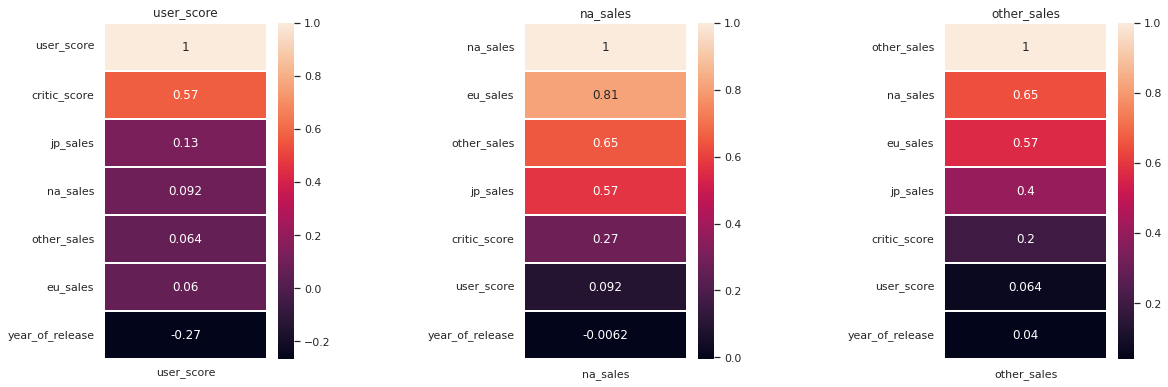

In [195]:
from scipy.stats.stats import pearsonr
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.set_theme()
fig.tight_layout(pad=15.0)

ax[0].set_title('user_score')
ax[1].set_title('na_sales')
ax[2].set_title('other_sales')

sns.heatmap(
    r_sampled.corr()[['user_score']].sort_values(by='user_score', ascending=False),
    annot=True,
    linewidths=0.25, 
    ax=ax[0]
)
sns.heatmap(
    r_sampled.corr()[['na_sales']].sort_values(by='na_sales', ascending=False),
    annot=True,
    linewidths=0.25, 
    ax=ax[1]
)
sns.heatmap(
    r_sampled.corr()[['other_sales']].sort_values(by='other_sales', ascending=False),
    annot=True,
    linewidths=0.25, 
    ax=ax[2]
)


plt.show()

In [196]:
transformed = r_sampled[['user_score', 'na_sales', 'other_sales', 'critic_score', 'eu_sales', 'jp_sales', 'year_of_release']]

In [197]:
from scipy.stats.stats import pearsonr
for val in transformed:
    print(val, ' : ', pearsonr(r_sampled['user_score'], r_sampled[val]))

user_score  :  (0.9999999999999996, 0.0)
na_sales  :  (0.0918879489970765, 5.857302936982976e-07)
other_sales  :  (0.06356401025942378, 0.0005562517551395353)
critic_score  :  (0.5720022721426183, 1.1766126047926077e-255)
eu_sales  :  (0.059777891869370436, 0.0011699991507108894)
jp_sales  :  (0.12792873195870058, 3.185168730778976e-12)
year_of_release  :  (-0.267928281471932, 1.3057342397405715e-49)


## **Step 4.** Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

In [198]:
transformed = r_sampled[['user_score', 'na_sales', 'other_sales', 'critic_score', 'eu_sales', 'jp_sales', 'year_of_release']]

In [199]:
edges_list = [
    ('user_score', 'critic_score'),
    ('na_sales', 'eu_sales'),
    ('na_sales', 'jp_sales'),
    ('na_sales', 'critic_score'),
    ('other_sales', 'na_sales'),
    ('other_sales', 'eu_sales'),
    ('other_sales', 'jp_sales'),
    ('other_sales', 'critic_score'),
    ('year_of_release', 'user_score')
]

our_model = BayesianModel(edges_list)

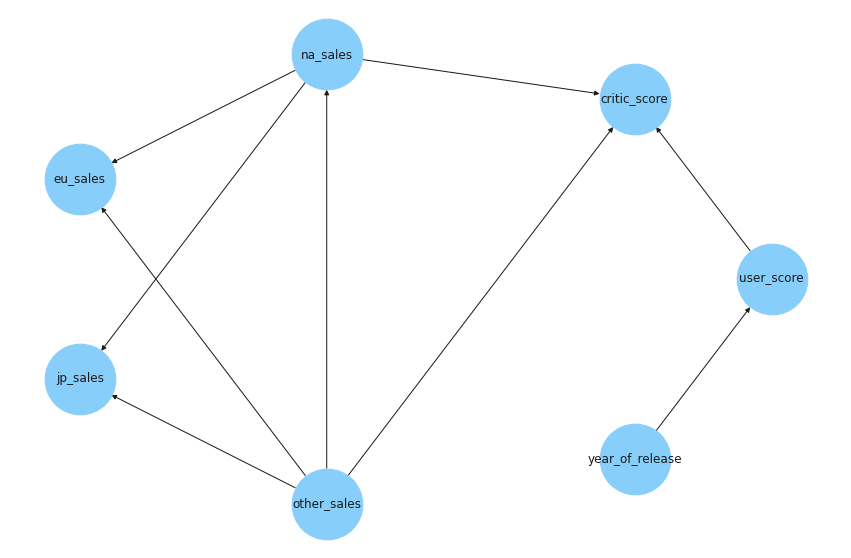

In [200]:
figure, ax = plt.subplots(1, 1, figsize=(15, 10))

graph = nx.DiGraph()
graph.add_edges_from(our_model.edges())

positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

In [201]:
to_discr = [2, 4, 5, 6, 7, 8, 9]

In [202]:
transformed_data = r_sampled.iloc[:, to_discr].copy()
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
transformed_data = discretizer.fit_transform(transformed_data.values)
r_sampled.iloc[:, to_discr] = transformed_data

In [203]:
r_sampled = r_sampled.drop(['name'], axis=1)

## **Step 5.** Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning.

In [204]:
hc = HillClimbSearch(data=r_sampled)
k2 = hc.estimate(scoring_method=K2Score(r_sampled))
bic = hc.estimate(scoring_method=BicScore(r_sampled))

In [205]:
k2.edges()

OutEdgeView([('platform', 'genre'), ('year_of_release', 'platform'), ('year_of_release', 'user_score'), ('genre', 'rating'), ('na_sales', 'critic_score'), ('na_sales', 'jp_sales'), ('eu_sales', 'na_sales'), ('jp_sales', 'year_of_release'), ('other_sales', 'eu_sales'), ('other_sales', 'na_sales'), ('other_sales', 'year_of_release'), ('critic_score', 'user_score')])

In [206]:
bic.edges()

OutEdgeView([('platform', 'year_of_release'), ('year_of_release', 'user_score'), ('genre', 'rating'), ('na_sales', 'eu_sales'), ('na_sales', 'jp_sales'), ('eu_sales', 'other_sales'), ('critic_score', 'na_sales'), ('user_score', 'critic_score'), ('rating', 'platform')])

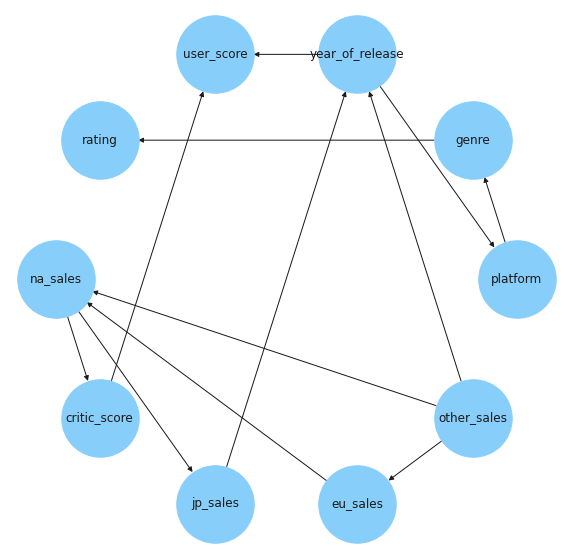

In [207]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = nx.DiGraph()
graph.add_edges_from(k2.edges())
nx.draw(graph, nx.layout.circular_layout(graph), with_labels=True, node_color='lightskyblue', node_size=6000)
plt.show()

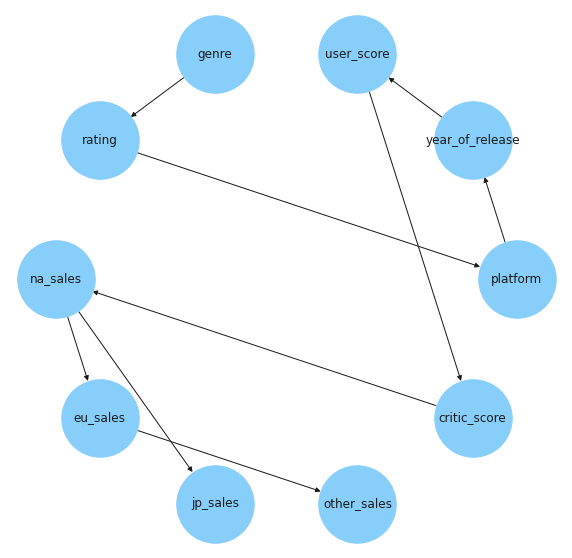

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = nx.DiGraph()
graph.add_edges_from(bic.edges())
nx.draw(graph, nx.layout.circular_layout(graph), with_labels=True, node_color='lightskyblue', node_size=6000)
plt.show()

In [209]:
#BDeuScore
bdeu = hc.estimate(scoring_method=BDeuScore(r_sampled))

In [210]:
bdeu.edges()

OutEdgeView([('platform', 'year_of_release'), ('year_of_release', 'user_score'), ('na_sales', 'eu_sales'), ('na_sales', 'critic_score'), ('na_sales', 'jp_sales'), ('na_sales', 'other_sales'), ('eu_sales', 'other_sales'), ('eu_sales', 'rating'), ('user_score', 'critic_score'), ('rating', 'genre'), ('rating', 'platform')])

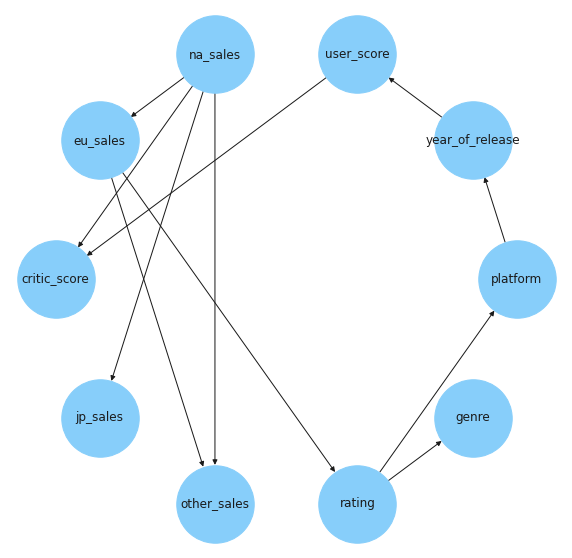

In [211]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = nx.DiGraph()
graph.add_edges_from(bdeu.edges())
nx.draw(graph, nx.layout.circular_layout(graph), with_labels=True, node_color='lightskyblue', node_size=6000)
plt.show()

In [212]:
e_search = TreeSearch(data=r_sampled)
e_model = e_search.estimate()

In [213]:
e_model.edges()

OutEdgeView([('platform', 'year_of_release'), ('platform', 'genre'), ('platform', 'user_score'), ('genre', 'rating'), ('user_score', 'critic_score'), ('critic_score', 'na_sales'), ('na_sales', 'eu_sales'), ('na_sales', 'jp_sales'), ('eu_sales', 'other_sales')])

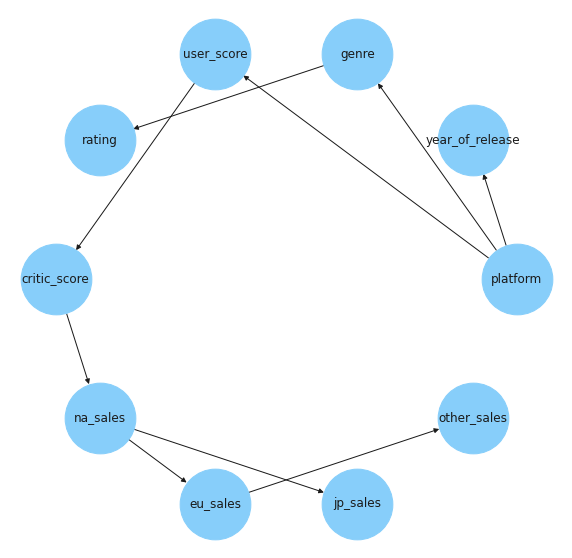

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = nx.DiGraph()
graph.add_edges_from(e_model.edges())
nx.draw(graph, nx.layout.circular_layout(graph), with_labels=True, node_color='lightskyblue', node_size=5000)
plt.show()

## **Step 6.** Analyze a quality of sampled target variables from the point of view of problem statement (e.g. prediction, gap filling, synthetic generation).

In [215]:
def sampling (bn, data: pd.DataFrame, n: int = 100):

    # data_continious = descritizer.inverse_transform(data.iloc[:, to_discr1].values)
    # data_continious = pd.DataFrame(data_continious)
    # sample_continious = descritizer.inverse_transform(samples.iloc[:, to_discr].values)
    # sample_continious = pd.DataFrame(sample_continious)

    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n)


    return sample

In [216]:

data_rmse = []
data_mape = []
data_r2 = []

In [217]:
def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, data_sampled: pd.DataFrame, axes=None):

    final_df = pd.DataFrame()
    
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    
    sns.barplot(ax=axes, x=parametr, y="Probability", hue="Data", data=final_df)

In [218]:
def discr(data, samples, descritizer = discretizer):
    data_continious = descritizer.inverse_transform(data.iloc[:, to_discr1].values)
    data_continious = pd.DataFrame(data_continious)
    sample_continious = descritizer.inverse_transform(samples.iloc[:, to_discr].values)
    sample_continious = pd.DataFrame(sample_continious)

    return data_continious, sample_continious

In [238]:
sample_K2 = sampling(k2, r_sampled)
sample_Bic = sampling(bic, r_sampled)
sample_BDeu = sampling(bdeu, r_sampled)

In [239]:
sample_our = sampling(our_model, r_sampled)
sample_tree = sampling(e_model, r_sampled)

In [234]:
sample_BDeu

,platform,year_of_release,user_score,na_sales,eu_sales,critic_score,jp_sales,other_sales,rating,genre
0,X360,3.0,4.0,0.0,0.0,3.0,0.0,0.0,T,Shooter
1,X360,3.0,1.0,0.0,0.0,1.0,0.0,0.0,E,Sports
2,PS3,4.0,1.0,0.0,0.0,1.0,0.0,0.0,T,Misc
3,PSP,3.0,4.0,0.0,0.0,3.0,0.0,0.0,E,Action
4,PS2,3.0,3.0,2.0,1.0,3.0,0.0,0.0,M,Racing
...,...,...,...,...,...,...,...,...,...,...
95,PS2,2.0,4.0,0.0,0.0,4.0,0.0,0.0,E,Racing
96,PS3,4.0,3.0,1.0,1.0,3.0,0.0,0.0,E,Racing
97,PS,1.0,4.0,0.0,0.0,3.0,0.0,0.0,E,Strategy
98,PS2,2.0,3.0,1.0,1.0,4.0,0.0,0.0,M,Shooter


In [235]:
to_discr = [2, 3, 5, 6, 7, 8, 9]
data, sample_K2 = discr(r_sampled, sample_K2)

to_discr = [1, 2, 5, 6, 7, 8, 9]
data, sample_Bic  = discr(r_sampled, sample_Bic)

to_discr = [1, 2, 3, 4, 5, 6, 7]
data, sample_BDeu  = discr(r_sampled, sample_BDeu)

to_discr = [0,1,2,3,4,5,6]
data, sample_our  = discr(r_sampled, sample_our)


to_discr = [1, 3, 5, 6, 7, 8, 9]
data, sample_tree  = discr(r_sampled, sample_tree)

In [237]:
data

,0,1,2,3,4,5,6
0,2002.840555,0.286454,0.205526,0.202432,0.124653,89.176089,8.727312
1,2012.854829,1.215531,0.205526,0.202432,0.124653,89.176089,7.372183
2,2002.840555,0.286454,0.205526,0.202432,0.124653,62.768298,7.372183
3,2007.263401,0.286454,0.205526,0.202432,0.124653,74.567406,7.372183
4,2002.840555,3.633653,0.946954,0.202432,0.124653,74.567406,7.372183
...,...,...,...,...,...,...,...
2941,2007.263401,1.215531,0.205526,0.202432,0.124653,89.176089,8.727312
2942,2007.263401,0.286454,0.205526,0.202432,0.124653,62.768298,7.372183
2943,2002.840555,0.286454,0.205526,0.202432,0.124653,74.567406,6.142162
2944,2007.263401,0.286454,0.205526,0.202432,0.124653,74.567406,6.142162


KeyError: KeyError: 'year_of_release'

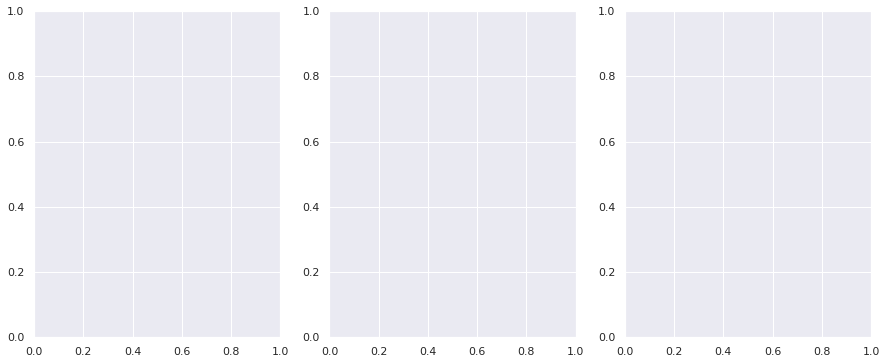

In [236]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

draw_comparative_hist('year_of_release', data, descritizer.inverse_transform(sample_K2['year_of_release'].values), axes=axes[0])
draw_comparative_hist('year_of_release', data, sample_Bic['year_of_release'].values, axes=axes[1])
draw_comparative_hist('year_of_release', data, sample_BDeu, axes=axes[2])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
axes[2].set_title('BDeu_Score')
plt.legend()
plt.show()

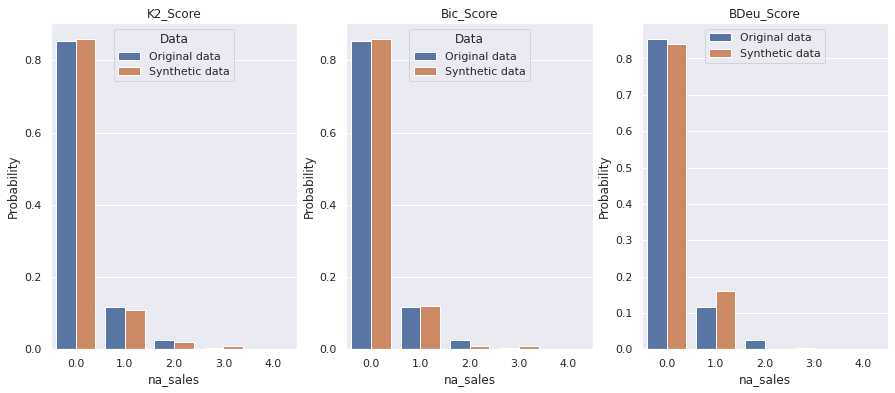

In [158]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

draw_comparative_hist('na_sales', data, sample_K2, axes=axes[0])
draw_comparative_hist('na_sales', data, sample_Bic, axes=axes[1])
draw_comparative_hist('na_sales', data, sample_BDeu, axes=axes[2])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
axes[2].set_title('BDeu_Score')
plt.legend()
plt.show()

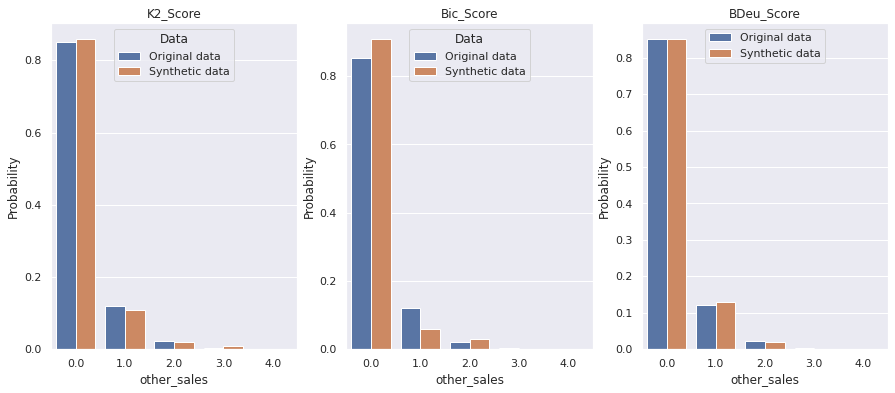

In [159]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

draw_comparative_hist('other_sales', data, sample_K2, axes=axes[0])
draw_comparative_hist('other_sales', data, sample_Bic, axes=axes[1])
draw_comparative_hist('other_sales', data, sample_BDeu, axes=axes[2])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
axes[2].set_title('BDeu_Score')
plt.legend()
plt.show()

In [160]:
to_discr1 = [1, 3, 4, 5, 6, 7,8]

In [161]:
sample_BDeu

,platform,year_of_release,other_sales,jp_sales,user_score,genre,rating,na_sales,critic_score,eu_sales
0,PS2,3.0,0.0,0.0,2.0,Simulation,T,0.0,2.0,0.0
1,PC,2.0,0.0,0.0,3.0,Shooter,E,0.0,3.0,0.0
2,PS4,4.0,0.0,0.0,3.0,Role-Playing,M,0.0,2.0,0.0
3,PS3,4.0,0.0,0.0,3.0,Action,T,0.0,3.0,0.0
4,X360,3.0,0.0,0.0,2.0,Shooter,M,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
95,PC,4.0,0.0,0.0,2.0,Shooter,M,0.0,4.0,0.0
96,PS2,3.0,0.0,0.0,1.0,Action,T,0.0,1.0,0.0
97,PS,1.0,0.0,0.0,3.0,Role-Playing,T,0.0,3.0,0.0
98,PS3,4.0,0.0,0.0,2.0,Shooter,M,0.0,0.0,0.0


In [162]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error as mape

def get_scores(data, samples, descritizer=discretizer):

    data_continious = descritizer.inverse_transform(data.iloc[:, to_discr1].values)
    data_continious = pd.DataFrame(data_continious)
    sample_continious = descritizer.inverse_transform(samples.iloc[:, to_discr].values)
    sample_continious = pd.DataFrame(sample_continious)

    y_true = data_continious[6].values[:100]
    y_pred = sample_continious[6].values

    corr_matrix = np.corrcoef(y_true, y_pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2

    print(f'R-2 score is: {R_sq}')
    print(f'RMSE is: {sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAE is: {mean_absolute_error(y_true, y_pred)}')
    return R_sq, sqrt(mean_squared_error(y_true, y_pred)), mape(y_true, y_pred)

In [163]:
sample_tree

,platform,year_of_release,genre,user_score,other_sales,rating,critic_score,na_sales,eu_sales,jp_sales
0,XB,3.0,Fighting,3.0,0.0,T,4.0,0.0,0.0,0.0
1,PC,3.0,Strategy,3.0,0.0,T,2.0,0.0,0.0,0.0
2,PS2,3.0,Action,3.0,0.0,E,3.0,0.0,0.0,0.0
3,PS3,4.0,Shooter,3.0,0.0,M,3.0,0.0,0.0,0.0
4,GC,2.0,Misc,2.0,0.0,T,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
95,DS,3.0,Sports,0.0,0.0,E,0.0,0.0,0.0,0.0
96,PS2,3.0,Simulation,4.0,0.0,T,1.0,0.0,0.0,0.0
97,GBA,2.0,Racing,2.0,0.0,T,1.0,0.0,0.0,0.0
98,GC,2.0,Racing,3.0,0.0,E,4.0,0.0,0.0,0.0


In [164]:

data_rmse = []
data_mape = []
data_r2 = []

to_discr = [2, 3, 5, 6, 7, 8, 9]
r2, rmse, mae = get_scores(r_sampled, sample_K2)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

to_discr = [1, 4,  5, 6, 7, 8, 9]
r2, rmse, mae = get_scores(r_sampled, sample_Bic)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

to_discr = [1, 2, 3, 4, 5, 6, 7]
r2, rmse, mae = get_scores(r_sampled, sample_BDeu)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

to_discr = [0,1,2,3,4,5,6]
r2, rmse, mae = get_scores(r_sampled, sample_our)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

to_discr = [1, 3, 4, 6, 7, 8, 9]
r2, rmse, mae = get_scores(r_sampled, sample_tree)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

R-2 score is: 7.081591889056935e-05
RMSE is: 2.158724469194803
MAE is: 1.5985236062602195


ValueError: ValueError: could not convert string to float: 'PS3'

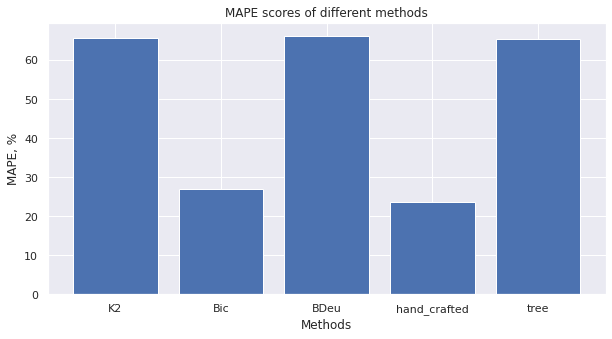

In [501]:
plt.figure(figsize=(10, 5))
x = ["K2", "Bic","BDeu", "hand_crafted", "tree"]
# y = [0.8242023774658618, 0.8898068766957087, 0.9200255171923536]
# y = data_aucs.values
plt.bar(x, [i*100 for i in data_mape])
plt.title('MAPE scores of different methods')
plt.xlabel('Methods')
plt.ylabel('MAPE, %')

plt.show()

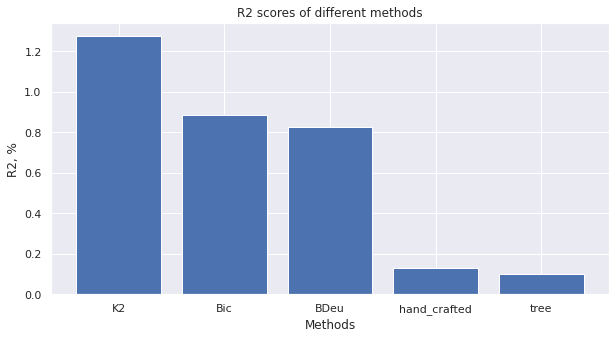

In [502]:
plt.figure(figsize=(10, 5))
x = ["K2", "Bic","BDeu", "hand_crafted", "tree"]
# y = [0.8242023774658618, 0.8898068766957087, 0.9200255171923536]
# y = data_aucs.values
plt.bar(x, [i*100 for i in data_r2])
plt.title('R2 scores of different methods')
plt.xlabel('Methods')
plt.ylabel('R2, %')

plt.show()

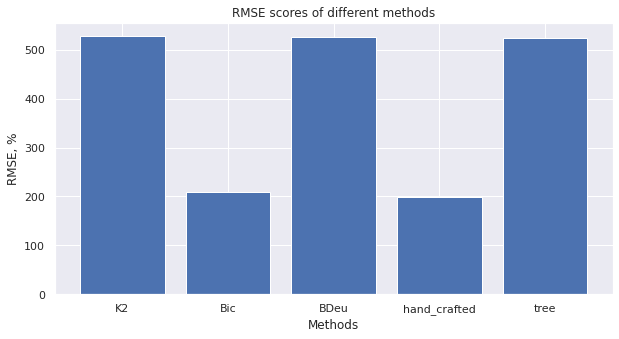

In [503]:
plt.figure(figsize=(10, 5))
x = ["K2", "Bic","BDeu", "hand_crafted", "tree"]
# y = [0.8242023774658618, 0.8898068766957087, 0.9200255171923536]
# y = data_aucs.values
plt.bar(x, [i*100 for i in data_rmse])
plt.title('RMSE scores of different methods')
plt.xlabel('Methods')
plt.ylabel('RMSE, %')

plt.show()

In [ ]:
r, p = scipy.stats.pearsonr(x, y)